## **Data Preparation**

In [1]:
from PIL import Image
from pathlib import Path
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
import numpy, torch, torch.nn as nn,torch, matplotlib.pyplot as plot

DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
PATH = Path('Data/NeuralNetwork')
SIZE = (224, 224)

training_transform = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validation_transform = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data = datasets.ImageFolder(PATH)

training_size = int(0.8 * len(data))
validation_size = len(data) - training_size

training_split, validation_split = random_split(data, [training_size, validation_size], generator=torch.Generator().manual_seed(42))

training_data = datasets.ImageFolder(PATH, transform=training_transform)
validation_data = datasets.ImageFolder(PATH, transform=validation_transform)

training_loader = DataLoader(Subset(training_data, training_split.indices), batch_size=32, shuffle=True)
validation_loader = DataLoader(Subset(validation_data, validation_split.indices), batch_size=32, shuffle=False)

print(f'Training: {len(training_split)} | Validation: {len(validation_split)}')
print(f'Batches - Train: {len(training_loader)} | Val: {len(validation_loader)}')

Training: 140 | Validation: 35
Batches - Train: 5 | Val: 2


## **Neural Network Architecture**

In [2]:
class CarDuckCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.dropout(nn.functional.relu(self.fc2(x)))
        return self.fc3(x)

model = CarDuckCNN().to(DEVICE)

total_parameters = sum(parameter.numel() for parameter in model.parameters())
bias_parameters = sum(parameter.numel() for name, parameter in model.named_parameters() if 'bias' in name)
weight_parameters = total_parameters - bias_parameters

print(model)
print()
print("="*70)
print(f"Total Parameters:  {total_parameters:,}")
print(f"Weight Parameters: {weight_parameters:,}")
print(f"Bias Parameters:   {bias_parameters:,}")
print("="*70)

CarDuckCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

Total Parameters:  25,800,194
Weight Parameters: 25,799,648
Bias Parameters:   546


# **Training the Model**

In [3]:
import time

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_count = 10

history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}

start_time = time.time()

for epoch in range(epoch_count):
    model.train()
    training_loss, training_correct, training_total = 0.0, 0, 0
    
    for images, labels in training_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        training_total += labels.size(0)
        training_correct += (predicted == labels).sum().item()
    
    model.eval()
    validation_loss, validation_correct, validation_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            validation_total += labels.size(0)
            validation_correct += (predicted == labels).sum().item()
    
    training_loss_avg = training_loss / len(training_loader)
    validation_loss_avg = validation_loss / len(validation_loader)
    training_acc = 100 * training_correct / training_total
    validation_acc = 100 * validation_correct / validation_total
    
    history['training_loss'].append(training_loss_avg)
    history['validation_loss'].append(validation_loss_avg)
    history['training_accuracy'].append(training_acc)
    history['validation_accuracy'].append(validation_acc)
    
    print(f'Epoch {epoch+1:<3d} > Training Loss: {training_loss_avg:.4f} Accuracy: {training_acc:<7.2f}% | Validation Loss: {validation_loss_avg:.4f} Accuracy: {validation_acc:<7.2f}%')

end_time = time.time()
training_time = end_time - start_time

print()
print("="*70)
print(f"Total Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print("="*70)

Epoch 1   > Training Loss: 0.9910 Accuracy: 54.29  % | Validation Loss: 0.7214 Accuracy: 57.14  %
Epoch 2   > Training Loss: 0.6944 Accuracy: 45.71  % | Validation Loss: 0.7291 Accuracy: 57.14  %
Epoch 3   > Training Loss: 0.6563 Accuracy: 52.14  % | Validation Loss: 0.6247 Accuracy: 62.86  %
Epoch 4   > Training Loss: 0.6956 Accuracy: 61.43  % | Validation Loss: 0.6147 Accuracy: 74.29  %
Epoch 5   > Training Loss: 0.6429 Accuracy: 55.00  % | Validation Loss: 0.7303 Accuracy: 60.00  %
Epoch 6   > Training Loss: 0.6455 Accuracy: 67.86  % | Validation Loss: 0.6822 Accuracy: 60.00  %
Epoch 7   > Training Loss: 0.5574 Accuracy: 75.00  % | Validation Loss: 0.8777 Accuracy: 68.57  %
Epoch 8   > Training Loss: 0.5829 Accuracy: 75.00  % | Validation Loss: 0.5231 Accuracy: 68.57  %
Epoch 9   > Training Loss: 0.4652 Accuracy: 76.43  % | Validation Loss: 0.9440 Accuracy: 71.43  %
Epoch 10  > Training Loss: 0.4824 Accuracy: 80.00  % | Validation Loss: 0.6311 Accuracy: 74.29  %

Total Training Time

## **Training and Validation Curves**

Visualizing the traininging and validationidation loss and accuracy over epochs.

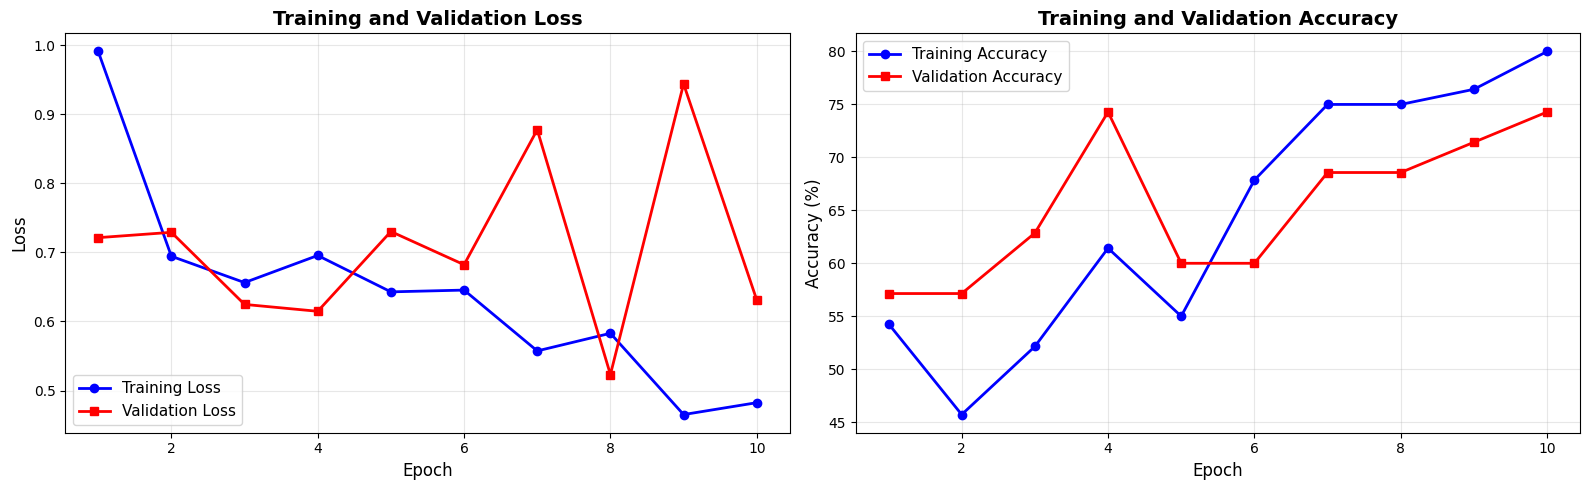


Final Training Accuracy: 80.00%
Final Validation Accuracy: 74.29%
Final Training Loss: 0.4824
Final Validation Loss: 0.6311


In [4]:
figure, (ax1, ax2) = plot.subplots(1, 2, figsize=(16, 5))
epochs = range(1, epoch_count + 1)

ax1.plot(epochs, history['training_loss'], 'b-', marker='o', label='Training Loss', linewidth=2)
ax1.plot(epochs, history['validation_loss'], 'r-', marker='s', label='Validation Loss', linewidth=2)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)

ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')

ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, history['training_accuracy'], 'b-', marker='o', label='Training Accuracy', linewidth=2)
ax2.plot(epochs, history['validation_accuracy'], 'r-', marker='s', label='Validation Accuracy', linewidth=2)

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)

ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
plot.tight_layout()
plot.show()

print(f'\nFinal Training Accuracy: {history["training_accuracy"][-1]:.2f}%')
print(f'Final Validation Accuracy: {history["validation_accuracy"][-1]:.2f}%')
print(f'Final Training Loss: {history["training_loss"][-1]:.4f}')
print(f'Final Validation Loss: {history["validation_loss"][-1]:.4f}')

## **Testing on All Conditions**

In [5]:
LABELS = ['realistic', 'features', 'blurred', 'geons', 'silhouettes']
TEST_PATH = Path('Data/Clustering')  
test_transform = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("="*70)
print("Testing on Car and Duck images from all conditions")
print("="*70)
print()

test_results = {}
for label in LABELS:
    label_dir = Path(TEST_PATH) / label
    images = []
    labels = []
    for img_path in sorted(label_dir.iterdir()):
        if 'Car' in img_path.stem:
            image = Image.open(img_path).convert('RGB')
            image = test_transform(image)
            images.append(image)
            labels.append(0)
        elif 'Duck' in img_path.stem:
            image = Image.open(img_path).convert('RGB')
            image = test_transform(image)
            images.append(image)
            labels.append(1)
    
    if len(images) == 0:
        print(f'{label:12s} | No car/duck images found')
        continue
    
    images_tensor = torch.stack(images)
    labels_tensor = torch.tensor(labels)
    test_dataset = TensorDataset(images_tensor, labels_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images_batch, labels_batch in test_loader:
            images_batch, labels_batch = images_batch.to(DEVICE), labels_batch.to(DEVICE)
            outputs = model(images_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()
    
    accuracy = 100 * correct / total
    test_results[label] = accuracy
    print(f'{label:12s} | Test Accuracy: {accuracy:<6.2f}% ({correct}/{total} correct)')

print()
print("="*70)
print(f'Average Test Accuracy across all conditions: {numpy.mean(list(test_results.values())):.2f}%')
print("="*70)

Testing on Car and Duck images from all conditions

realistic    | Test Accuracy: 50.00 % (5/10 correct)
features     | Test Accuracy: 80.00 % (8/10 correct)
blurred      | Test Accuracy: 77.78 % (7/9 correct)
geons        | Test Accuracy: 66.67 % (10/15 correct)
silhouettes  | Test Accuracy: 50.00 % (5/10 correct)

Average Test Accuracy across all conditions: 64.89%
